In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

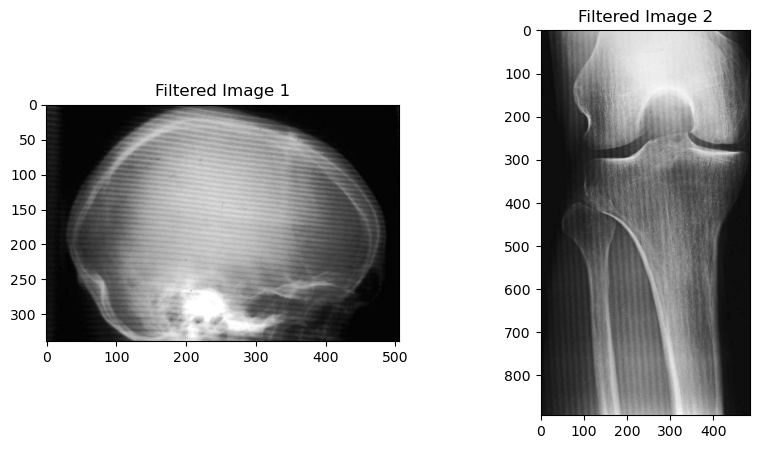

Chosen window size N: 1


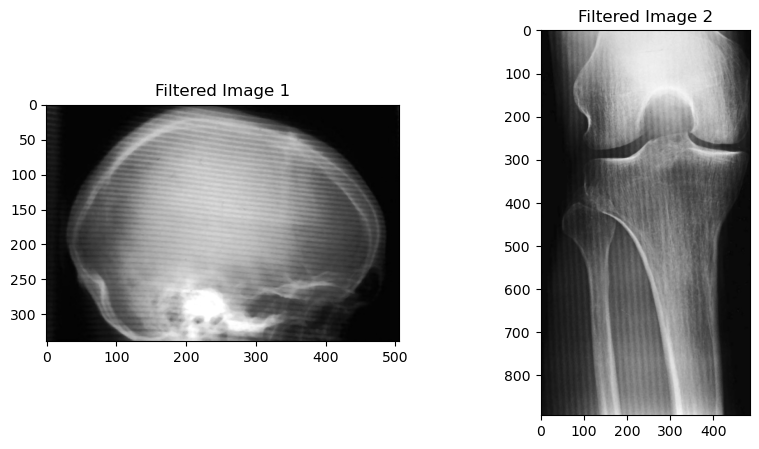

Chosen window size N: 3


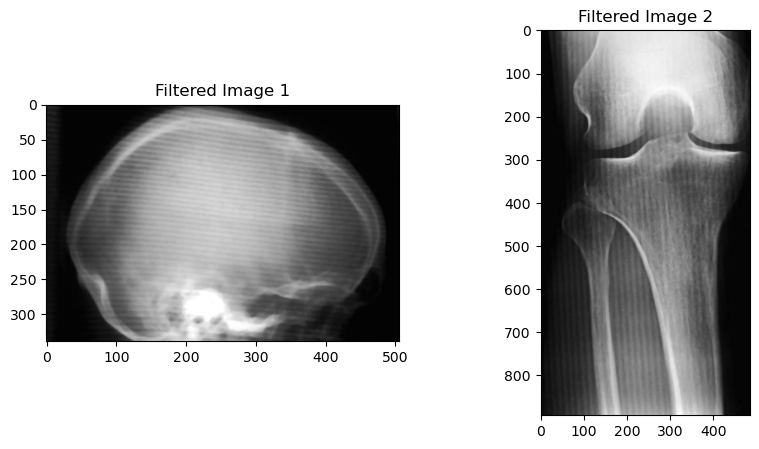

Chosen window size N: 5


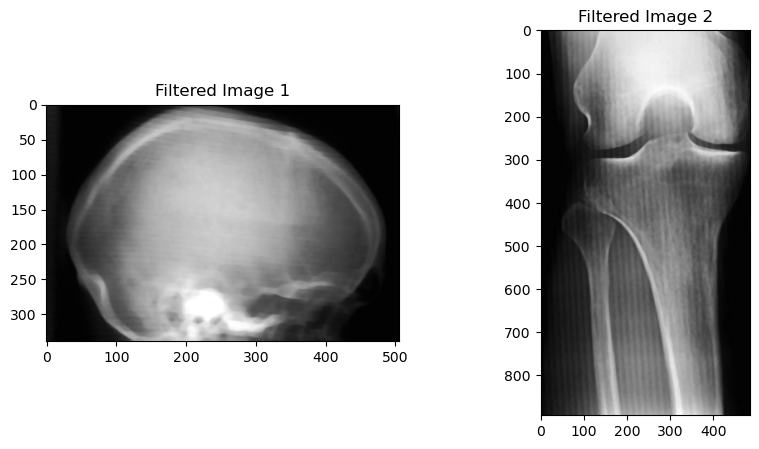

Chosen window size N: 7


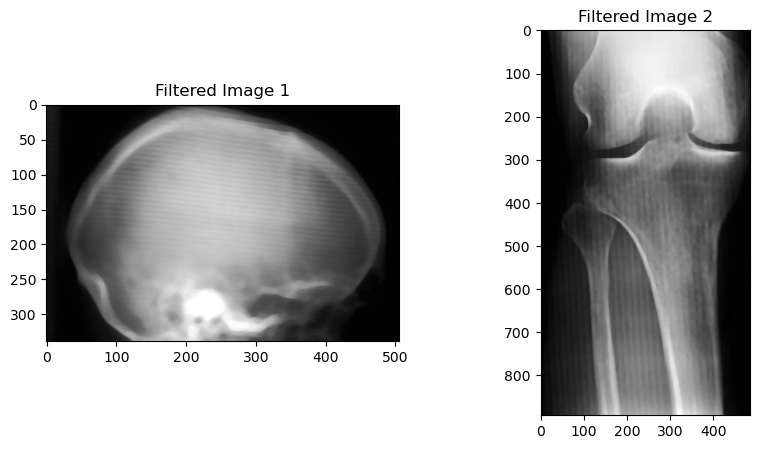

Chosen window size N: 9


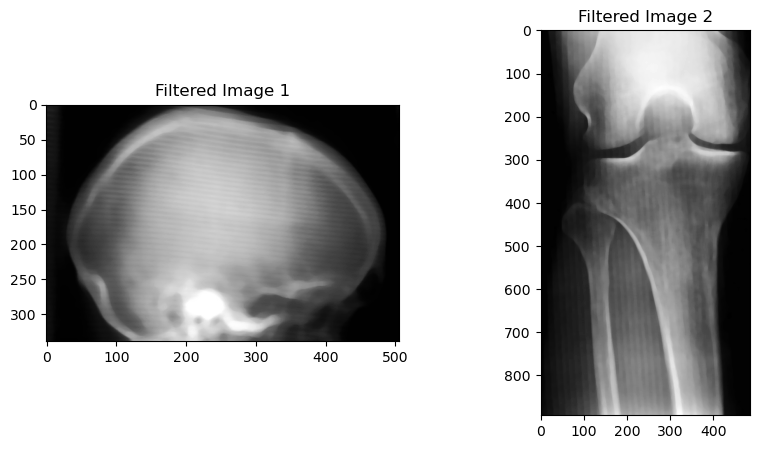

Chosen window size N: 11


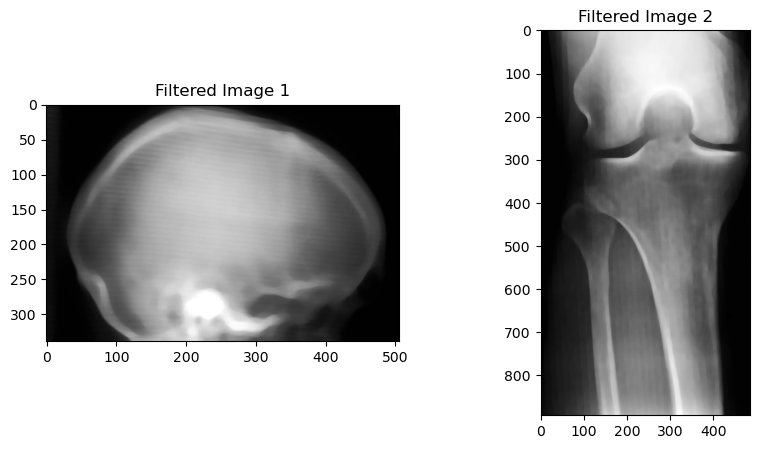

Chosen window size N: 13


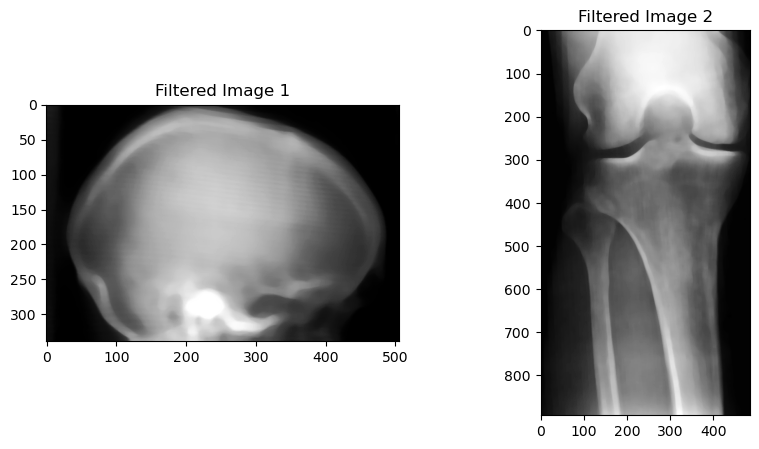

Chosen window size N: 15


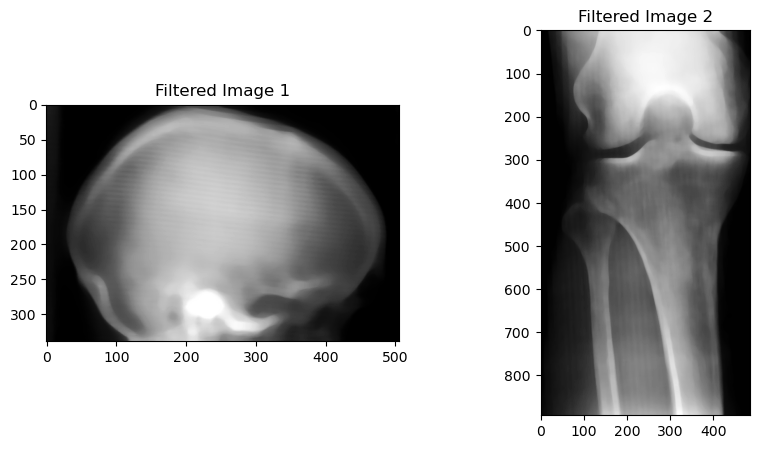

Chosen window size N: 17


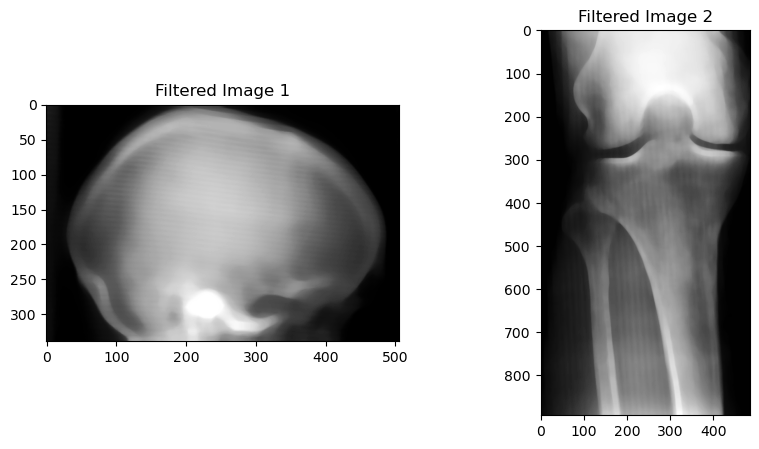

Chosen window size N: 19


In [26]:
# Note: for img1, 7 is the best size, for img2, is 15

from scipy.ndimage import median_filter # since it has been down before...
def apply_median_filter(img_path, N):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    filtered_img = median_filter(img, size=N)
    return img, filtered_img

img1_path = 'pro3_radiograph_1.jpg'
img2_path = 'pro3_radiograph_2.jpg'

N = 1  # Note: for img1, 7 is the best size, for img2, is 15.
for i in range (1, 20, 2):
    N = i
    img1, filtered_img1 = apply_median_filter(img1_path, N)
    img2, filtered_img2 = apply_median_filter(img2_path, N)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(filtered_img1, cmap='gray')
    plt.title('Filtered Image 1')
    plt.subplot(1, 2, 2)
    plt.imshow(filtered_img2, cmap='gray')
    plt.title('Filtered Image 2')
    plt.show()

    # Report N
    print(f'Chosen window size N: {N}')

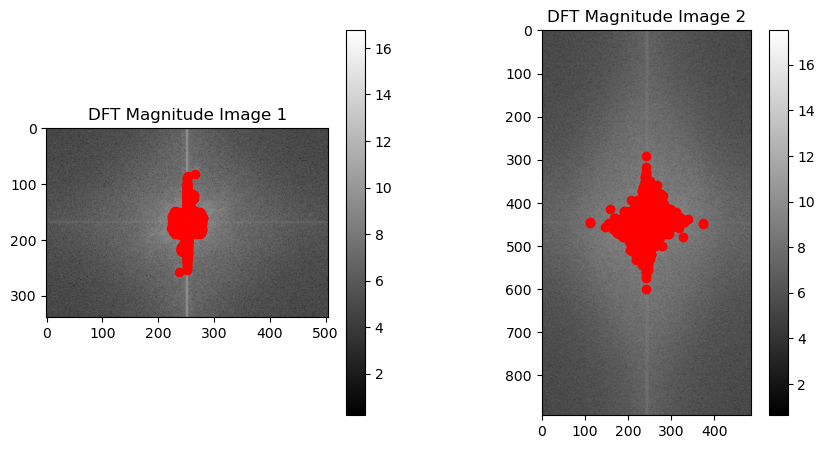

In [27]:
def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return img

def compute_dft(img):
    # Fourier and centered
    dft = np.fft.fftshift(np.fft.fft2(img))
    magnitude_spectrum = np.log(np.abs(dft) + 1)
    return dft, magnitude_spectrum

def identify_moire_patterns(magnitude_spectrum, threshold=10):
    # recognize frequency of img
    rows, cols = magnitude_spectrum.shape
    crow, ccol = rows // 2 , cols // 2 
    mask = magnitude_spectrum > threshold
    mask[crow-10:crow+10, ccol-10:ccol+10] = False
    moire_points = np.argwhere(mask)

    return moire_points

def mark_moire_patterns(magnitude_spectrum, moire_points):
    # mark moire patterns
    plt.imshow(magnitude_spectrum, cmap='gray')
    for point in moire_points:
        plt.plot(point[1], point[0], 'ro')
    plt.colorbar()

img1 = load_image(img1_path)
img2 = load_image(img2_path)

# caculate dft
dft1, dft_magnitude1 = compute_dft(img1)
dft2, dft_magnitude2 = compute_dft(img2)

moire_points1 = identify_moire_patterns(dft_magnitude1, threshold=10)
moire_points2 = identify_moire_patterns(dft_magnitude2, threshold=10)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
mark_moire_patterns(dft_magnitude1, moire_points1)
plt.title('DFT Magnitude Image 1')
plt.subplot(1, 2, 2)
mark_moire_patterns(dft_magnitude2, moire_points2)
plt.title('DFT Magnitude Image 2')
plt.show()


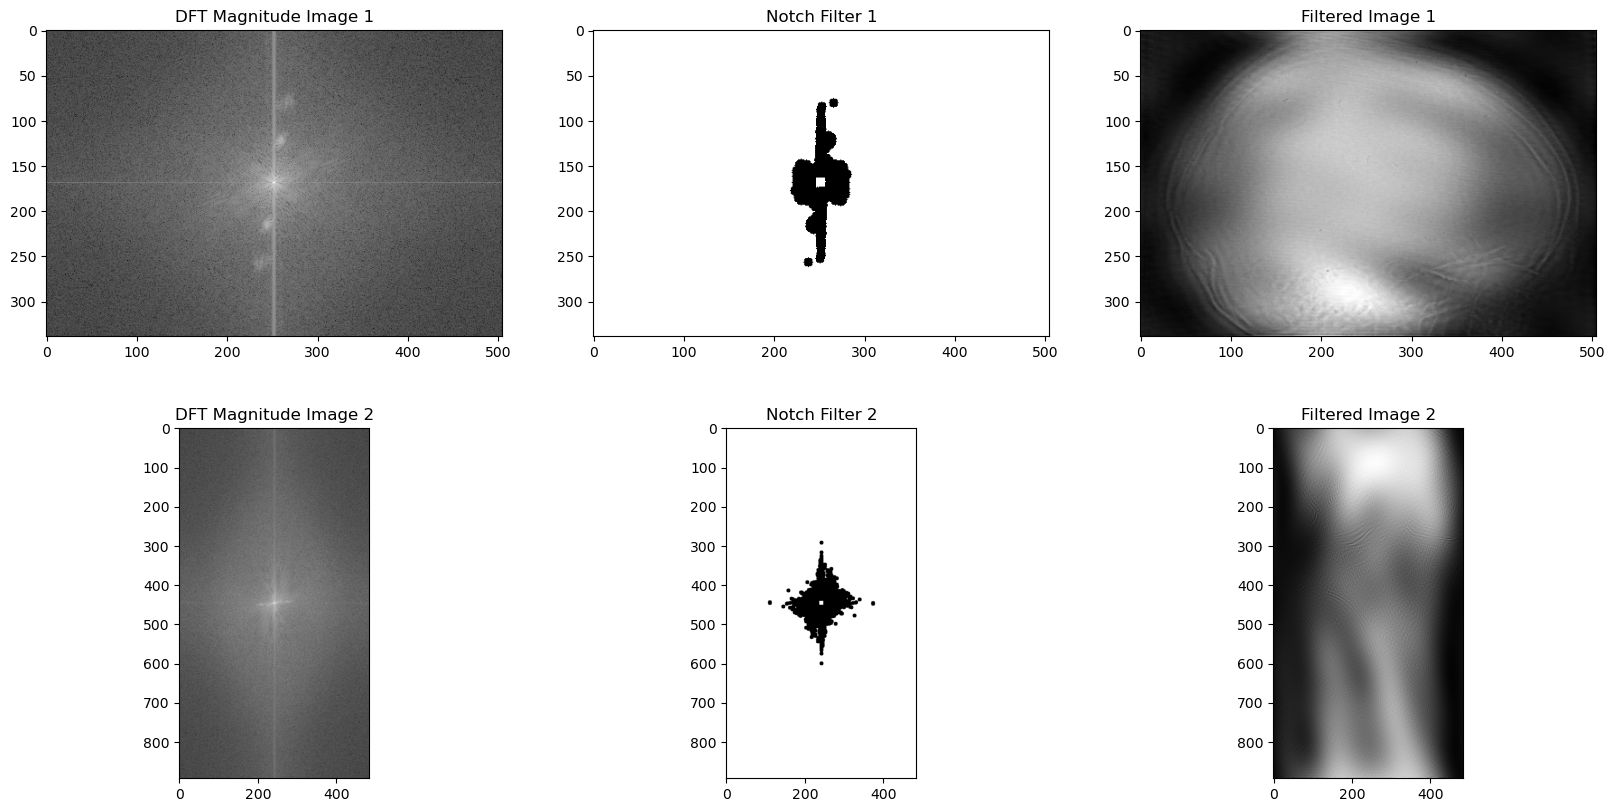

In [28]:
def design_notch_filter(shape, moire_points, radius=5):
    # notch
    rows, cols = shape
    crow, ccol = rows // 2 , cols // 2
    notch_filter = np.ones((rows, cols), dtype=np.float32)
    
    for point in moire_points:
        r, c = point
        rr, cc = np.ogrid[:rows, :cols]
        mask_area = (rr - r) ** 2 + (cc - c) ** 2 <= radius ** 2
        notch_filter[mask_area] = 0

    return notch_filter

def apply_notch_filter(dft, notch_filter):
    # notch to Fourier
    filtered_dft = dft * notch_filter
    return filtered_dft

img1 = load_image(img1_path)
img2 = load_image(img2_path)


dft1, dft_magnitude1 = compute_dft(img1)
dft2, dft_magnitude2 = compute_dft(img2)

# recoginze freq part of moore grapth
moire_points1 = identify_moire_patterns(dft_magnitude1, threshold=10)
moire_points2 = identify_moire_patterns(dft_magnitude2, threshold=10)

# notch
notch_filter1 = design_notch_filter(dft_magnitude1.shape, moire_points1, radius=5)
notch_filter2 = design_notch_filter(dft_magnitude2.shape, moire_points2, radius=5)
filtered_dft1 = apply_notch_filter(dft1, notch_filter1)
filtered_dft2 = apply_notch_filter(dft2, notch_filter2)

# reverse f
filtered_img1 = np.fft.ifft2(np.fft.ifftshift(filtered_dft1))
filtered_img2 = np.fft.ifft2(np.fft.ifftshift(filtered_dft2))

filtered_img1 = np.abs(filtered_img1)
filtered_img2 = np.abs(filtered_img2)


plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.imshow(dft_magnitude1, cmap='gray')
plt.title('DFT Magnitude Image 1')

plt.subplot(2, 3, 2)
plt.imshow(notch_filter1, cmap='gray')
plt.title('Notch Filter 1')

plt.subplot(2, 3, 3)
plt.imshow(filtered_img1, cmap='gray')
plt.title('Filtered Image 1')

plt.subplot(2, 3, 4)
plt.imshow(dft_magnitude2, cmap='gray')
plt.title('DFT Magnitude Image 2')

plt.subplot(2, 3, 5)
plt.imshow(notch_filter2, cmap='gray')
plt.title('Notch Filter 2')

plt.subplot(2, 3, 6)
plt.imshow(filtered_img2, cmap='gray')
plt.title('Filtered Image 2')

plt.show()